# Homework 4: Word Embeddings and Neural Language Models


Names: __Suzanne Becker, Yuval Timen__

Step 1: Word2Vec paper questions
---------------------------

### 1. Describe how a CBOW word embedding is generated.

A CBOW word embedding can be created by using the CBOW algorithm. This would consist of training a classifier to predict a target word given some context words, and taking the weights of the trained classifier to be the embeddings. Specifically, given the sequence of length M $w_{0} ... w_{M}$ and a window size N, we would first create one-hot vectors for each word in the sequence. These will be used as inputs to the classifier. Then for each time step $t$, we will be trying to predict the word $w_{t}$ given the context words within the N-sized window. We take the N words from either side of $w_{t}$, namely $w_{t-N}...w_{t+N}$ excluding $w_{t}$. These will each be fed through the forward pass of the classifier, which will give an output vector of size 1xV, representing the probability distribution of predicting the next word over our entire vocabulary. The error for each iteration in training will be the sum of the errors for all context words. We do the backward propagation, and once the weights have been updated, we move to the next timestep and shift our target word to be the next word in the sequence ($w_{t+1}$), and repeat the training steps; for each timestep, we run the forward pass, find the error, and do backpropagation.

Once we complete training, our CBOW embeddings will be the weights we have learned. The weight matrix is of size VxE, where E is the size of the embeddings we want to learn. Thus we have V vectors each of length E, meaning that for each word in our vocabulary, we've created an embedding of length E.

(We drew from source #2 to get a better understanding of how CBOW embeddings are created.)

### 2. What is a CBOW word embedding and how is it different from a skip-gram word embedding?

A CBOW word embedding is an embedding created using the CBOW algorithm - namely, embeddings learned by training a Neural Network to predict some target given some number of neighboring context words. This is very similar to the skip-gram method for generating word embeddings. The main difference is that, during the prediction task, CBOW tries to predict the target word given some neighboring context words, while skip-gram tries to predict the context words given a target word.

(this answer is also informed by source #2)

### 3. What is the task that the authors use to evaluate the generated word embeddings?

They tested that the word embeddings preserved the linear relationships between words; ideally, they wanted to have __vector("King") - vector("Man") + vector("Woman") = vector("Queen")__. They tested this by creating a large test set of 5 types of semtantic relationships and 9 types of syntactic questions. This was done by manually creating a list of word pairs, for example __(Athens, Greece)__ or __(great, greater)__. Then, each of these word pairs was connected to another word word pair in the same syntactic/semantic category, and the evaluation task consisted of seeing if the embeddings could accurately predict the second word in the second pair, given the relationship computed from the first pair. For example, given __(Athens, Greece)__ $\to$ __(Oslo, Norway)__, they computed the vectors for each of the first 3 words, did the vector math, and saw whether the result was the correct last word: __vector(Athens) - vector(Greece) + vector(Oslo) =? vector(Norway)__.

(We referenced 

### 4. What are PCA and t-SNE? Why are these important to the task of training and interpreting word embeddings?

PCA (or Principal Component Analysis) is a method of finding the set of dimensions in a vector space which maximizes the variance in each dimension. This is done by taking linear combinations of our other features to try to find the first PC dimension which maximizes the variance of our data. Then, each subsequent PCA dimension is calculated using the same method, with the added condition that the new dimension must be orthogonal to all other PC dimensions. This effectively is a way of projecting the data from $\mathbb{R}^{N} \to \mathbb{R}^{N}$, where the new vector space's axes are sorted in order of "importance" or information. To use PCA to visualize word embeddings, we can run PCA on our embedding space, and then take the first 2 or 3 PCA dimensions and use them to visualize our embeddings in a 2 or 3 dimensional space.

On the other hand, t-SNE is a method for visualizing high-dimensional data while also trying to avoid the "curse of dimensionality". When our data lives in high-dimensional vector spaces, simply projecting the space onto a 2 or 3 dimensional plane will cause our data to overcrowd. This makes it very hard to see clusters or any other meaningful relationship between the data. t-SNE solves this problem by modeling the distribution of points in the high-dimensional space, and then re-creating that distribution in a lower dimensional space. The points in 2-d are sampled according to the distribution, meaning that the user of t-SNE gets to control how many points are sampled. This will avoid the overcrowding problem and will still allow us to visualize our high-dimensional data.

PCA and t-SNE are important in training and interpreting word embeddings because they provide a human-interpretable view on generated vector embeddings, which are otherwise long lists of numbers with no inherent semantic meaning to the human eye. Projecting vector embeddings into smaller-dimensional space would potentially reveal clusters in 2 or 3 dimensions which will allow us to visually inspect the quality of our embeddings: does each cluster contain words that we as humans would consider "similar"?

Step 2: Train your own word embeddings
--------------------------------

# The Spooky Author Dataset

We first examine the aptly named Spooky Authors dataset. This is a compilation of works from Edgar Allan Poe, H.P. Lovecraft, and Mary Shelley, and can be accessed on Kaggle [here](https://www.kaggle.com/c/spooky-author-identification/overview). Since we will be dealing with embeddings (ie. contexts of words), the connotation of the data is important to consider. We expect to be seeing 'spooky' bias in the embeddings to some extent. 

# Our Dataset: Collected works of Nietzsche

__Describe what data set you have chosen to compare and contrast with the Spooky Authors Dataset. Make sure to describe where it comes from and its general properties.__

We chose to work with the writings of Friedrich Nietzsche, a prolific philosopher and author. We downloaded a collection of his publications from [Project Gutenberg](https://www.gutenberg.org/ebooks/author/779). Altogether, there are over 893,000 words in the corpus we collected. Nietzsche wrote a lot about human nature, life, and society, so we would expect to see greater representation of words related to being, speaking, thinking, and social organization and structure. As a philosopher, he also questions the nature of our existence and the world we have created, so his writing will also probably include more sentences structured as questions. 

After downloading 14 of Nietzsche's books, we manually removed the preface metadata and any prefacing information that was not part of the original text. Then, we wrote a Python script to do the following: 
* programmatically remove "footer" text (Project Gutenberg books all end with something like "*** End of this Project Gutenberg book...")
* remove chapter headings containing "Chapter", digits, or Roman numerals, using a regex 
* split the text into sentences and compile all sentences from all books into a single document, `nietzsche_sentences.txt`

In [1]:
# Imports
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
# This is a faster implementation of TSNE that Yuval found 
from MulticoreTSNE import MulticoreTSNE as TSNE

%matplotlib inline
%load_ext wurlitzer

# Some constants
EMBEDDINGS_SIZE = 300
SPOOKY_DATA_PATH_TEST = "./data_files/spooky_test.csv"
SPOOKY_DATA_PATH_TRAIN = "./data_files/spooky_train.csv"
NIETZSCHE_DATA_PATH = "./data_files/nietzsche_sentences.txt"

In [2]:
# Read in the data
with open(SPOOKY_DATA_PATH_TRAIN, newline='') as f:
    reader = csv.reader(f)
    reader.__next__()  # skip the column names 
    train = [row[1] for row in reader]  # Take only the text data
    
with open(SPOOKY_DATA_PATH_TEST, newline='') as f:
    reader = csv.reader(f)
    reader.__next__()  # skip the column names
    test = [row[1] for row in reader]  # Take only the text data
    
# Use all the spooky data
sentences_spooky = train + test

# Read in the Nietzsche data
with open(NIETZSCHE_DATA_PATH, 'r') as f:
  # read the lines into a list
  sentences_niet = [line.strip() for line in f]

Data Pre-processing
--------------------------------

We first clean and then organize our data into a list-of-list-of strings. Each inner list represents a sentence. 

The input to the data cleaning step (`clean_data`) is a list of sentence strings. 

To clean a sentence, we first change it to entirely lowercase. Next, we remove all punctuation and numbers, replacing them with a whitespace. Then, we remove quotation marks and replace them with whitespace, being careful to preserve any single quotes that are part of contractions. 

After cleaning the sentence strings, we apply Python's .split() operator to each sentence in the list, resulting in a list of lists of words.

In [3]:
# Data pre-processing/cleaning

# Lowercases all words, removes punctuation, 
# and replaces all instances of a number with whitespace
def clean_data(sentences):
    regex_punctuation = r'([.,;:_"\/\\\(\)\[\]!?<>]|--)'
    regex_numbers = r'[0-9]'
    
    # Regexes matching a single quote that:
    # - precedes a word 
    # - follows a word
    # - is not next to a word
    regex_single_quote_start = "([^a-zA-Z])\\'([a-zA-Z])"
    regex_single_quote_end = "([a-zA-Z])\\'([^a-zA-Z])"
    regex_single_quote_standalone = "([^a-zA-Z])\\'([^a-zA-Z])"
    
    output = []
    
    for sent in sentences:
        tmp = sent.lower()
        tmp = re.sub(regex_punctuation, ' ', tmp)
        tmp = re.sub(regex_numbers, ' ', tmp)
        tmp = re.sub(regex_single_quote_start, r'\1 \2', tmp)
        tmp = re.sub(regex_single_quote_end, r'\1 \2', tmp)
        tmp = re.sub(regex_single_quote_standalone, r'\1 \2', tmp)
        output.append(tmp)
    
    return output

sentences_spooky = clean_data(sentences_spooky)
sentences_niet = clean_data(sentences_niet)

# Turn each sentence into a list of words
sentences_listed_spooky = [sentence.split() for sentence in sentences_spooky]
sentences_listed_niet = [sentence.split() for sentence in sentences_niet]

Data Exploration & Statistics
----------------------------------

We generate some basic statistics about the two corpuses, such as sentence and word count, sentence and word length, and vocab size. 

In [4]:
# Data exploration

# Prints some basic statistics about our dataset:
# 1. Total Number of Sentences
# 2. Average Sentence Length in Words
# 3. Total Number of Words
# 4. Average Word Length in Characters
# 5. Vocabulary Size
# (The function returns the list of all words in the dataset)
def print_dataset_statistics(sentences):
    num_sentences = len(sentences)
    avg_sent_length = np.mean([len(sent.split()) for sent in sentences])
    all_words = []
    for sent in sentences:
        all_words.extend(sent.split())
    avg_word_length = np.mean([len(word) for word in all_words])
    num_words = len(all_words)
    vocab_size = len(set(all_words))
    
    print(f"Total sentences: {num_sentences}")
    print(f"Average sentence length: {round(avg_sent_length, 3)} words")
    print(f"Total number of words: {num_words}")
    print(f"Average word length {round(avg_word_length, 3)} characters")
    print(f"Vocabulary size: {vocab_size}")
    
    return all_words

print("---Spooky dataset statistics---")
all_words_spooky = print_dataset_statistics(sentences_spooky)
print("\n---Nietzsche dataset statistics---")
all_words_niet = print_dataset_statistics(sentences_niet)

---Spooky dataset statistics---
Total sentences: 27971
Average sentence length: 26.633 words
Total number of words: 744958
Average word length 4.483 characters
Vocabulary size: 29027

---Nietzsche dataset statistics---
Total sentences: 103741
Average sentence length: 8.615 words
Total number of words: 893702
Average word length 4.647 characters
Vocabulary size: 31371


### a) Train embedding on GIVEN dataset

In [5]:
# Create the embeddings, save the KeyedVector, toss the model
model_spooky = Word2Vec(sentences=sentences_listed_spooky, size=EMBEDDINGS_SIZE, sg=1, window=5, min_count=1)
spooky_embeddings = model_spooky.wv
del model_spooky

### b) Train embedding on YOUR dataset

In [6]:
model_niet = Word2Vec(sentences=sentences_listed_niet, size=EMBEDDINGS_SIZE, sg=1, window=5, min_count=1)
niet_embeddings = model_niet.wv
del model_niet

Step 3: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

In [7]:
# This function prints some quick similarities and comparisons for the given embeddings
def quick_evaluate_embeddings(embeddings):
    
    similar_to_king = embeddings.most_similar('king')[0][0]
    similar_to_horse = embeddings.most_similar('horse')[0][0]
    similar_to_man = embeddings.most_similar('man')[0][0]
    king_minus_man_plus_woman = embeddings.most_similar(positive=['king', 'woman'], negative=['man'])[0][0]
    odd_one_out_food = embeddings.doesnt_match(('bread', 'meat', 'vegetables', 'peasant'))
    odd_one_out_days = embeddings.doesnt_match(('monday', 'wednesday', 'friday', 'favorite'))
    odd_one_out_animals = embeddings.doesnt_match(('cat', 'dog', 'sheep', 'wolf', 'hose'))

    print(f"Word most similar to 'king': {similar_to_king}")
    print(f"Word most similar to 'horse': {similar_to_horse}")
    print(f"Word most similar to 'man': {similar_to_man}")
    print(f"King - Man + Woman: {king_minus_man_plus_woman}")
    print(f"Was the model able to distinguish 'peasant' from food? {odd_one_out_food == 'peasant'}")
    print(f"Was the model able to distinguish 'favorite' from weekdays? {odd_one_out_days == 'favorite'}")
    print(f"Was the model able to distinguish 'train' from animals? {odd_one_out_animals == 'train'}")
    

print('Output for Spooky Embeddings:')
quick_evaluate_embeddings(spooky_embeddings)
print('--------------------------------------')
print('Output for Nietzsche Embeddings')
quick_evaluate_embeddings(niet_embeddings)

Output for Spooky Embeddings:
Word most similar to 'king': heir
Word most similar to 'horse': wrist
Word most similar to 'man': woman
King - Man + Woman: married
Was the model able to distinguish 'peasant' from food? True
Was the model able to distinguish 'favorite' from weekdays? True
Was the model able to distinguish 'train' from animals? False
--------------------------------------
Output for Nietzsche Embeddings
Word most similar to 'king': magician
Word most similar to 'horse': reins
Word most similar to 'man': woman
King - Man + Woman: wrote
Was the model able to distinguish 'peasant' from food? False
Was the model able to distinguish 'favorite' from weekdays? True
Was the model able to distinguish 'train' from animals? False


/usr/local/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [10]:
# Building the t-SNE projection

# This is the V x E matrix; the full-length embedding for each vocab word
# Each unique word $w_{i}$ represents the row $V_{i}$
# Each row is a vector of length E which corresponds to that word's embedding 
embedding_matrix_spooky = spooky_embeddings[spooky_embeddings.vocab]
embedding_matrix_niet = niet_embeddings[niet_embeddings.vocab]
print(f"Original shape of the spooky matrix: {embedding_matrix_spooky.shape}")  # (31851, 300)
print(f"Original shape of the philosophical matrix: {embedding_matrix_niet.shape}")  # (31851, 300)


# We first run PCA and keep the first num_components dimensions before we pass into t-SNE
num_components = 50
random_seed = 100

pca_spooky = PCA(n_components=num_components)
pca_embeddings_spooky = pca_spooky.fit_transform(embedding_matrix_spooky)
pca_niet = PCA(n_components=num_components)
pca_embeddings_niet = pca_niet.fit_transform(embedding_matrix_niet)
print(f"New shape of the spooky matrix: {pca_embeddings_spooky.shape}")  # (31851, 50)
print(f"New shape of the philosophical matrix: {pca_embeddings_niet.shape}")  # (31851, 50)

# Since we ran PCA and kept only the first few dimensions, we want to know how much
# of the original information is still preserved in this projection. The concept of
# "explained variance" is helpful here. Our original 300-dimensional vector space has 
# a certain amount of variance among the data. This is our "total variance". When we 
# project to 50 dimensions, we lose some of that variance, since we lose dimensions along
# which our data can vary. We calculate the total amount of variance in our 50-dimensional
# space and divide that number by our total variance. This yields the amount of variance 
# preserved after our projection. So while our data might not have *all* of the original
# variance, we can still see that it has a significant percentage of the total variance, and
# so we only lose a small amount of information while reducing our space a lot. Thanks PCA!
print(f"SPOOKY: Cumulative explained variance of first {num_components} PC dimensions: {100 * round(np.sum(pca_spooky.explained_variance_ratio_), 3)}%")
print(f"PHILOSOPHICAL: Cumulative explained variance of first {num_components} PC dimensions: {100 * round(np.sum(pca_niet.explained_variance_ratio_), 3)}%")

Original shape of the spooky matrix: (29027, 300)
Original shape of the philosophical matrix: (31371, 300)
New shape of the spooky matrix: (29027, 50)
New shape of the philosophical matrix: (31371, 50)
SPOOKY: Cumulative explained variance of first 50 PC dimensions: 99.19999837875366%
PHILOSOPHICAL: Cumulative explained variance of first 50 PC dimensions: 98.19999933242798%


In [11]:
# Now we run t-SNE
tsne_spooky = TSNE(n_components=2, perplexity=45, verbose=True, random_state=random_seed, n_iter=500)
tsne_embeddings_spooky = tsne_spooky.fit_transform(pca_embeddings_spooky)

Performing t-SNE using 1 cores.
Using no_dims = 2, perplexity = 45.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 2902 of 29027
 - point 5804 of 29027
 - point 8706 of 29027
 - point 11608 of 29027
 - point 14510 of 29027
 - point 17412 of 29027
Iteration 201: error is 88.119088 (50 iterations in 17.00 seconds)
 - point 20314 of 29027
 - point 23216 of 29027
 - point 26118 of 29027
 - point 29020 of 29027
Done in 10.00 seconds (sparsity = 0.007400)!
Learning embedding...
Iteration 251: error is 87.838722 (50 iterations in 17.00 seconds)
Iteration 51: error is 103.140513 (50 iterations in 20.00 seconds)
Iteration 301: error is 3.779221 (50 iterations in 15.00 seconds)
Iteration 101: error is 93.892409 (50 iterations in 18.00 seconds)
Iteration 351: error is 3.493916 (50 iterations in 16.00 seconds)
Iteration 151: error is 89.027821 (50 iterations in 18.00 seconds)
Iteration 401: error is 3.336537 (50 iterations in 17.00 seconds)
Iteration 201: err

In [12]:
# Now we run t-SNE (again)
tsne_niet = TSNE(n_components=2, perplexity=45, verbose=True, random_state=random_seed, n_iter=500)
tsne_embeddings_niet = tsne_niet.fit_transform(pca_embeddings_niet)

Performing t-SNE using 1 cores.
Using no_dims = 2, perplexity = 45.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 3137 of 31371
 - point 6274 of 31371
 - point 9411 of 31371
 - point 12548 of 31371
 - point 15685 of 31371
 - point 18822 of 31371
 - point 21959 of 31371
 - point 25096 of 31371
 - point 28233 of 31371
 - point 31370 of 31371
Done in 14.00 seconds (sparsity = 0.007002)!
Learning embedding...
Iteration 51: error is 103.461055 (50 iterations in 17.00 seconds)
Iteration 101: error is 94.781716 (50 iterations in 17.00 seconds)
Iteration 151: error is 91.548276 (50 iterations in 24.00 seconds)
Iteration 201: error is 89.503827 (50 iterations in 20.00 seconds)
Iteration 251: error is 88.135018 (50 iterations in 18.00 seconds)
Iteration 301: error is 3.886597 (50 iterations in 18.00 seconds)
Iteration 351: error is 3.611823 (50 iterations in 14.00 seconds)
Iteration 401: error is 3.464341 (50 iterations in 16.00 seconds)
Iteration 451: err

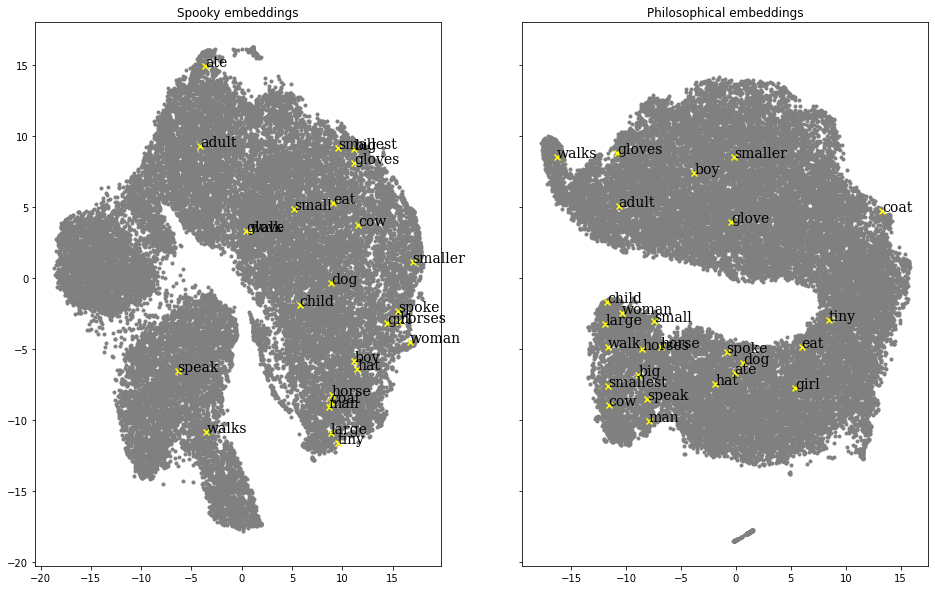

In [21]:
# Visualizing the data

vis_x_spooky = tsne_embeddings_spooky[:, 0]
vis_y_spooky = tsne_embeddings_spooky[:, 1]

vis_x_niet = tsne_embeddings_niet[:, 0]
vis_y_niet = tsne_embeddings_niet[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 10))

ax1.scatter(vis_x_spooky, vis_y_spooky, c='grey', marker='.')
ax2.scatter(vis_x_niet, vis_y_niet, c='grey', marker='.')


def visualize_clusters(current_ax, embeddings, tsne_model):
    # We highlight the location of several words of interest on this chart.
    words_of_interest = ('man', 'woman', 'boy', 'girl', 'child', 'adult',
                         'coat', 'hat',  'glove', 'gloves',
                         'dog', 'horse', 'horses', 'cow',
                         'large', 'big', 'tiny', 'small', 'smaller', 'smallest', 
                        'walk', 'walks', 'speak', 'spoke', 'eat', 'ate')
    vectors_of_interest = []
    # Need to look up the index of the word to find its corresponding t-SNE vector
    for word in words_of_interest:
        idx_of_word = embeddings.vocab[word].index
        vectors_of_interest.append(tsne_model.embedding_[idx_of_word])

    # Text styling parameters
    font= {'family':'serif','color':'black','weight':'normal','size':14}

    # Draw the words of interest on and label them
    for idx, vec in enumerate(vectors_of_interest):
        current_ax.scatter(vec[0], vec[1], c='yellow', marker='x')
        current_ax.text(vec[0], vec[1], words_of_interest[idx], fontdict=font)

        
visualize_clusters(ax1, spooky_embeddings, tsne_spooky)
visualize_clusters(ax2, niet_embeddings, tsne_niet)
ax1.set_title('Spooky embeddings')
ax2.set_title('Philosophical embeddings')
plt.show()

Step 4: Feedforward Neural Language Model
--------------------------

### a) First, encode  your text into integers

In [22]:
# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

NGRAM = 4  # The size of the ngram language model we will train

In [23]:
# First, we map each word to a unique index
tokenizer_spooky = Tokenizer()
tokenizer_spooky.fit_on_texts(sentences_listed_spooky)
sentences_listed_unique_id_spooky = tokenizer_spooky.texts_to_sequences(sentences_listed_spooky)


tokenizer_niet = Tokenizer()
tokenizer_niet.fit_on_texts(sentences_listed_niet)
sentences_listed_unique_id_niet = tokenizer_niet.texts_to_sequences(sentences_listed_niet)

In [58]:
# This function will return a single numpy array of 
# length (N-1)xE, where N is the n-gram order (implicitly, the length of our iterable), 
# and E is the length of our embedding. The output is a concatenation of the 
# word embeddings in our iterable. 
def concat_word_embeddings(iterable, embeddings):
    disjoint_embeddings = [spooky_embeddings.get_vector(word) for word in iterable]
    return np.concatenate(disjoint_embeddings).T

mini_concat = ['did', 'you', 'win']

# We expect the resulting shape to be len(mini_concat) * EMBEDDINGS_SIZE
print("Resulting shape from concatenating the word embeddings for mini-concat:")
print(concat_word_embeddings(mini_concat, spooky_embeddings).shape)
print("Expected shape from concatenating the word embeddings for mini-concat:")
print((len(mini_concat) * EMBEDDINGS_SIZE,))

Resulting shape from concatenating the word embeddings for mini-concat:
(900,)
Expected shape from concatenating the word embeddings for mini-concat:
(900,)


In [60]:
# We format our data to be passed into the model

# This function will take our encoded list of lists
# It will return a generator which yields values like ([([x1, x2, ... , x(n-1)], y) ...]
# In this case, each X_i will be the word embedding corresponding to that word
def data_to_xy_tuples(data, n_gram, tokenizer, embeddings):
    num_classes = max(tokenizer.word_index.values()) + 1
    for sentence in data:
        if len(sentence) < n_gram:
            continue
        for i in range(len(sentence) - n_gram):
            yield (concat_word_embeddings(sentence[i : n_gram + i], embeddings), 
                   to_categorical(tokenizer.texts_to_sequences(sentence[n_gram + i]), num_classes=num_classes))

# Test that data_to_xy_tuples works properly
mini_test = [['welcome', 'back'], ['hope', 'you', 'had', 'a', 'good', 'weekend']]
tok = Tokenizer()
tok.fit_on_texts(mini_test)



indexed = tok.texts_to_sequences(mini_test)
print(indexed)
one_hot = [to_categorical(i) for i in indexed]
print(one_hot)

print("Result of the test sequence being separated into tuples")
for x, y in data_to_xy_tuples(mini_test, 3, tok, spooky_embeddings):
    print(f"{x.shape} -> {y.shape}")

# Finally, let's prepare our data sequence to be fed into the model
data_generator_spooky = data_to_xy_tuples(sentences_listed_spooky, NGRAM, tokenizer_spooky, spooky_embeddings)
data_generator_niet = data_to_xy_tuples(sentences_listed_niet, NGRAM, tokenizer_niet, niet_embeddings)

[[1, 2], [3, 4, 5, 6, 7, 8]]
[array([[0., 1., 0.],
       [0., 0., 1.]], dtype=float32), array([[0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)]
Result of the test sequence being separated into tuples
(900,) -> (1, 9)
(900,) -> (4, 0, 9)
(900,) -> (7, 0, 9)


In [48]:
# Let's create the models

neural_lm_spooky = Sequential()
neural_lm_spooky.add(Input(shape=(NGRAM * EMBEDDINGS_SIZE,)))
neural_lm_spooky.add(Dense(100, activation='tanh'))
neural_lm_spooky.add(Dense(50, activation='relu'))
neural_lm_spooky.add(Dense(len(tokenizer_spooky.index_word.keys()), activation='softmax'))

neural_lm_spooky.compile(loss='categorical_crossentropy', optimizer='sgd')

neural_lm_niet = Sequential()
neural_lm_niet.add(Input(shape=(NGRAM * EMBEDDINGS_SIZE,)))
neural_lm_niet.add(Dense(100, activation='tanh'))
neural_lm_niet.add(Dense(50, activation='relu'))
neural_lm_niet.add(Dense(len(tokenizer_niet.index_word.keys()), activation='softmax'))

neural_lm_niet.compile(loss='categorical_crossentropy', optimizer='sgd')


print(neural_lm_spooky.summary())
print(neural_lm_niet.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 100)               120100    
_________________________________________________________________
dense_27 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_28 (Dense)             (None, 29027)             1480377   
Total params: 1,605,527
Trainable params: 1,605,527
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 100)               120100    
_________________________________________________________________
dense_30 (Dense)             (None, 50)                5050      
________________

In [57]:
# Training the models

neural_lm_spooky.fit(data_generator_spooky, epochs=1)

neural_lm_niet.fit(data_generator_niet, epochs=1)

ValueError: in user code:

    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_9 is incompatible with the layer: expected axis -1 of input shape to have value 1200 but received input with shape [None, 1]


### b) Next, prepare your sequences from text

#### Fixed ngram based sequences (Used for Feedforward)

In [ ]:
def generate_ngram_training_samples():
    '''
    Takes the encoded data (list of lists) and generates the training samples 
    out of it.
    Parameters:
    up to you!
    return: list of lists in the format [[x1, x2, ... , x(n-1), y], ...]
    '''
    pass


### c) Then, split the sequences into X and y and create a Data Generator

In [ ]:
# Note here that the sequences were in the form: 
# sequence = [x1, x2, ... , x(n-1), y]
# We still need to separate it into [[x1, x2, ... , x(n-1)], ...], [y1, y2, ...]

In [ ]:
def read_embeddings():
    '''Loads and parses embeddings trained in earlier.'''
    
    # you may find generating the following two dicts useful:
    # word to embedding : {'the':1, ...}
    # index to embedding : {1:'the', ...} (inverse of word_2_embedding)
    pass


# remember that "0" index is assigned for padding token. 
# Hence, initialize the vector for padding token as all zeros of embedding size

In [ ]:
def data_generator(X, y, num_sequences_per_batch):
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels (see the to_categorical function)
    '''
    



In [ ]:
# Examples
# initialize data_generator
# num_sequences_per_batch = 1024 # or Batch Size
# steps_per_epoch = len(sequences)//num_sequences_per_batch  # Number of batches per epoch
# train_generator = data_generator(X, y, num_sequences_per_batch)

# sample=next(train_generator) # this is how you get data out of generators
# sample[0].shape # (batch_size, (n-1)*EMBEDDING_SIZE)

### d) Train your models

In [ ]:
# code to train a feedforward neural language model 
# on a set of given word embeddings
# make sure not to just copy + paste to train your two 

# Defining the model architecture using Keras Sequential API


In [ ]:
# Start training the model
model.fit_generator(train_generator, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=1)

### e) Generate Sentences

In [ ]:
# generate a sequence from the model
def generate_seq(model, tokenizer, seed, n_words):
    '''
    Parameters:
        model: your neural network
        tokenizer: the keras preprocessing tokenizer
        seed: [w1, w2, w(n-1)]
        n_words: generate a sentence of length n_words
    Returns: string sentence
    '''
    pass

### f) Compare your generated sentences

Sources Cited
----------------------------


1. https://github.com/DmitryUlyanov/Multicore-TSNE (FAST T-SNE)
2. Kulshethra, Ria. "NLP 101: Word2Vec — Skip-gram and CBOW". Accessed November 8, 2020. https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314   (Used to answer the questions about CBOW and skip-gram.)
3. Wang, Bin et al. "Evaluating Word Embedding Models: Methods and Experimental Results". https://arxiv.org/abs/1901.09785
4. Winastwan, Rubin. "Visualizing Word Embedding with PCA and t-SNE". Accessed November 8, 2020. https://towardsdatascience.com/visualizing-word-embedding-with-pca-and-t-sne-961a692509f5
5. Kurita, Keita. "Paper Dissected: “Visualizing Data using t-SNE” Explained". Accessed November 8, 2020. https://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/
6. Brownlee, Jason. "How to Develop a Word-Level Neural Language Model and Use it to Generate Text". Accessed November 8, 2020. https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/